# Определение успешности игр в зависимости от платформ, стран выпуска, жанров

В моем распоряжении данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Мои задачи — обработать данные и привести их в нужный для анализа вид, сравнить продажи в разрезе по региону продаж, по платформам, оценить вероятность сравнительно одинакового рейтинга платформ, жанров.


In [1]:
#импортируем пандас, изучаем данные
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()
data.head()

In [3]:
#изучаем уникальне значения столбцов
for column in data.columns:
    print('====================')
    print(column)
    print(data[column].value_counts())
    print(data[column].unique())

Name
Need for Speed: Most Wanted                                     12
Madden NFL 07                                                    9
Ratatouille                                                      9
LEGO Marvel Super Heroes                                         9
FIFA 14                                                          9
                                                                ..
Dead or Alive Xtreme 3: Venus                                    1
Godzilla (2014)                                                  1
UFO: Trilogy                                                     1
Arcana Heart                                                     1
Makai Senki Disgaea Portable: Tsuushin Taisen Hajime Mashita     1
Name: Name, Length: 11559, dtype: int64
['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica']
Platform
PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP 

Вывод: Нужно привести к нижнему регистру названия столбцов 
- удалить пропуски в столбце year_of_release (поскольку их мало)
- привести к целочисленному виду столбце year_of_release поскольку год всегда целое число
- выяснить являются ли дубликатами повторы в наименовании игр
- поменять тип данных в столбце user_score и заменить tbd на NAN
- удалить строки с играми категрий EC, K-A, RP, AO поскольку их мало и они искажают картину в графиках.

## . Подготовка данных

In [4]:
# отсортировал без малочисленных категорий рейтинга
data = data.query("Rating not in ['EC', 'K-A', 'RP', 'AO']")

In [5]:
# приведем наименование столбцов в нижний регистр
data.columns = map(str.lower, data.columns)
data.head(30)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [6]:
# удалил пропуски в столбце и привел к целочисленному виду
data = data.dropna(subset=['year_of_release'])
data['year_of_release'] = data['year_of_release'].astype(int)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16433 entries, 0 to 16714
Data columns (total 11 columns):
name               16431 non-null object
platform           16433 non-null object
year_of_release    16433 non-null int64
genre              16431 non-null object
na_sales           16433 non-null float64
eu_sales           16433 non-null float64
jp_sales           16433 non-null float64
other_sales        16433 non-null float64
critic_score       7980 non-null float64
user_score         9826 non-null object
rating             9755 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [7]:
# выяснил, что tbd это значит "будет определено", то есть на момент выгрузки данных оценка выставлена не была и будет определена
data['user_score'].value_counts()

tbd    2369
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.6       2
2.3       2
1         2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [8]:
#заменил tbd на nan  и перевел в тип float поскольку оценка пользователей измеряется в числах,
#и судя по данным столбца оценка может быть в виде десятичной дроби
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')
data['user_score'] = data['user_score'].astype(float)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16433 entries, 0 to 16714
Data columns (total 11 columns):
name               16431 non-null object
platform           16433 non-null object
year_of_release    16433 non-null int64
genre              16431 non-null object
na_sales           16433 non-null float64
eu_sales           16433 non-null float64
jp_sales           16433 non-null float64
other_sales        16433 non-null float64
critic_score       7980 non-null float64
user_score         7457 non-null float64
rating             9755 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Пропуски в столбцах оценок решил не заполнять медианой, поскольку пропусков много и тем самым может исказиться общая картина оценок игр. Причина пропусков в столбце оценка пользователей может объясняться простым отсутствием информации об оценках по конкретной игре. К тому же замечено, что оценка отсутствует в большинстве случаев по всем трем столбцам с оценками, что говорит об отсутствии деятельности по сбору информации об оценках этой игры.

In [9]:
# добавим столбец общие продажи
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16433 entries, 0 to 16714
Data columns (total 12 columns):
name               16431 non-null object
platform           16433 non-null object
year_of_release    16433 non-null int64
genre              16431 non-null object
na_sales           16433 non-null float64
eu_sales           16433 non-null float64
jp_sales           16433 non-null float64
other_sales        16433 non-null float64
critic_score       7980 non-null float64
user_score         7457 non-null float64
rating             9755 non-null object
total_sales        16433 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


## Анализ данных.

In [10]:
# группируем по году выпуска
year_game = data.groupby('year_of_release').agg({'name': ['count']})
year_game

,name
,count
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16


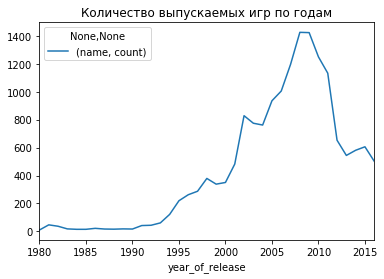

In [11]:
year_game.plot()
plt.title('Количество выпускаемых игр по годам');

Поскольку нам нужно спланировать компанию на следующий год, то будет достаточно данных за последние допустим 4-5 лет. Данные за 2012 - 2016 годы в целом без выдающихся в ту или иную сторону показателей. После быстрого роста конца нулевых и падения начала десятых можно сделать вывод, что индустрия игр вышла на условное "плато". То есть прорыва, как и падения ожидать маловероятно.

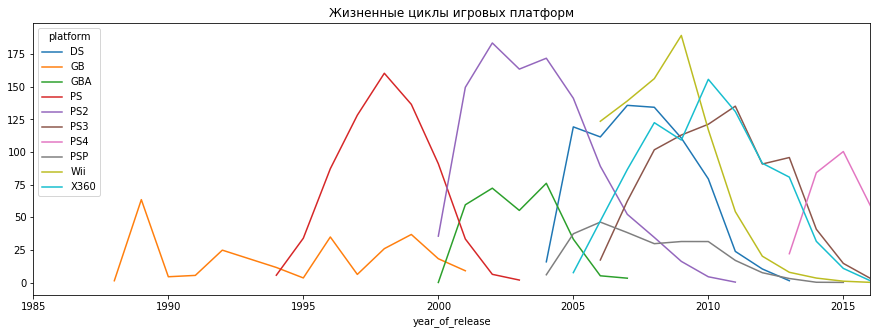

In [12]:
#создадим топ 10 платформ
top_10 = data.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by = 'total_sales').tail(10).index

data.query('platform in @top_10').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(15,5));
plt.title('Жизненные циклы игровых платформ');

Средний срок жизни платформы 7-10 лет после которых продажи стремятся к нулю. Исходя из этого предположу, что актуальным периодом можно считать срок в 8 лет, исходя из количества выпускаемых по годам игр и среднего срока жизни платформы.

In [13]:
actual_period = data.groupby(['platform','year_of_release']).agg({'total_sales': 'sum'}).query('platform in @ top_10 and total_sales > 1')
pd.set_option('display.max_columns', None)
actual_period

total_sales
platform year_of_release             
DS       2004                   15.91
         2005                  119.34
         2006                  111.64
         2007                  135.85
         2008                  134.37
...                               ...
X360     2012                   91.45
         2013                   80.82
         2014                   31.61
         2015                   10.86
         2016                    1.40

[98 rows x 1 columns]

In [14]:
# расчитает жизненный период каждой платформы
actual_period = data.groupby(['platform','year_of_release']).agg({'total_sales': 'sum'}).query('platform in @ top_10 and total_sales > 1')
actual_period = actual_period.reset_index().groupby('platform').agg({'year_of_release': 'count'})
actual_period

,year_of_release
platform,
DS,10
GB,13
GBA,7
PS,10
PS2,11
PS3,11
PS4,4
PSP,10
Wii,10


In [15]:
# расчитает сколько в среднем живет платформа
actual_period.mean() 

year_of_release    9.8
dtype: float64

In [16]:
data_top_10 = data.query('year_of_release >=2013 and platform in @ top_10')
data_top_10.info()
data_top_10.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16433 entries, 0 to 16714
Data columns (total 12 columns):
name               16431 non-null object
platform           16433 non-null object
year_of_release    16433 non-null int64
genre              16431 non-null object
na_sales           16433 non-null float64
eu_sales           16433 non-null float64
jp_sales           16433 non-null float64
other_sales        16433 non-null float64
critic_score       7980 non-null float64
user_score         7457 non-null float64
rating             9755 non-null object
total_sales        16433 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 2.3+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,74.09
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,39.47
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,30.38


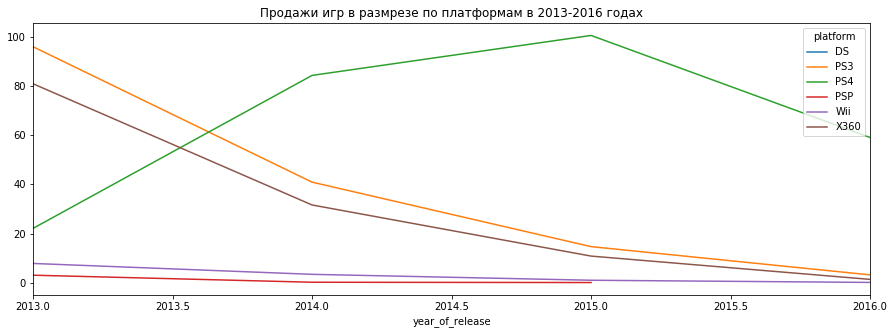

In [17]:
data_top_10.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(15,5));
plt.title('Продажи игр в размрезе по платформам в 2013-2016 годах');

In [18]:
data_top_10.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

platform,DS,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,
2013,1.42,95.85,22.12,3.10,7.87,80.82
2014,NaN,40.88,84.22,0.24,3.45,31.61
2015,NaN,14.70,100.44,0.12,1.05,10.86
2016,NaN,3.23,59.01,NaN,0.17,1.40


На данный момент в живых платформах может числится разве что PS4. Остальные либо находятся в практически в стадии минимальных продаж без переспектив роста, либо уж отсутствуют в продажах.

In [19]:
data_top_5 = data_top_10.query("platform not in ['DS']")

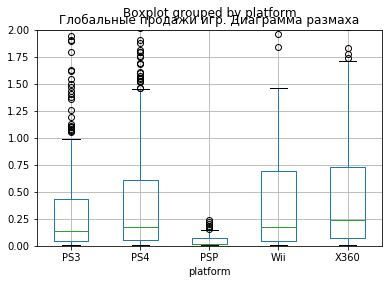

In [20]:
#Строим диаграммы размаха для столбца платформа
data_top_5.boxplot(column='total_sales', by='platform')
plt.ylim(0,2)
plt.title('Глобальные продажи игр. Диаграмма размаха');
plt.show();

Наиболее максимальный разброс в играх на платформах X360 и Wii. Медиана платформы X360 выше, что говорит о больших продажах в актуальном периоде. Но стоит заметить, что большие продажи в прошлом и в данный момент в конце 2016 года продажи в сравнении с серией PS минимальны.

0.3657935752138173


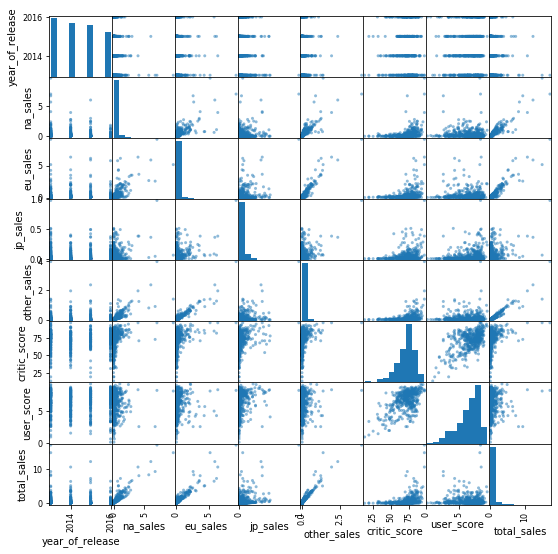

In [21]:
# считаем корреляцию 
data_top_5.query('platform == "PS4"')
print(data_top_5['total_sales'].corr(data['critic_score']))
pd.plotting.scatter_matrix(data_top_5, figsize=(9, 9));

Корреляция не выражена сильно.

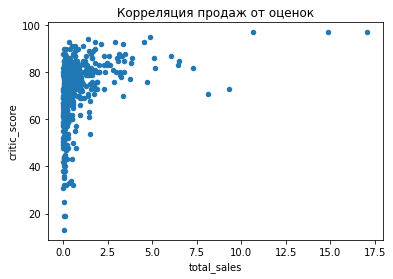

In [22]:
data_top_5.plot(x='total_sales', y='critic_score', kind='scatter')
plt.title('Корреляция продаж от оценок');

-0.006253301251877529


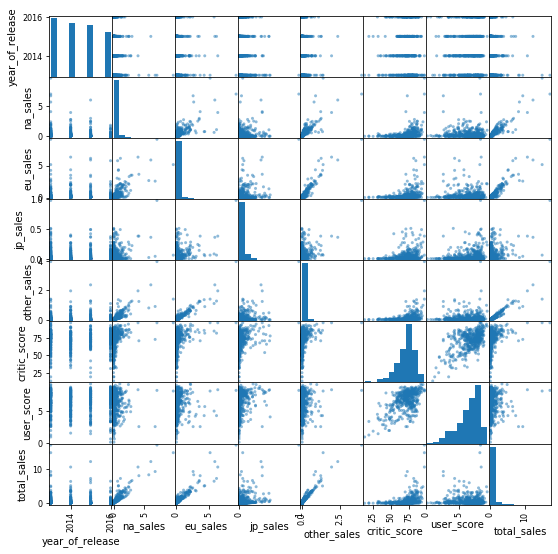

In [23]:
data_top_5.query('platform == "PS4"')
print(data_top_5['total_sales'].corr(data_top_5['user_score']))
pd.plotting.scatter_matrix(data_top_5, figsize=(9, 9));

корреляция между продажами и оценками слабая.

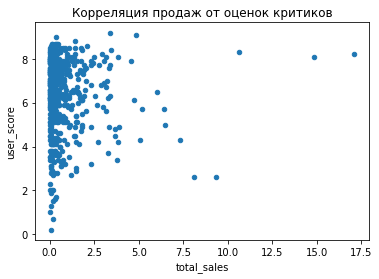

In [24]:
data_top_5.plot(x='total_sales', y='user_score', kind='scatter')
plt.title('Корреляция продаж от оценок критиков');

In [25]:
genre_sales = data_top_5.pivot_table(index='genre', values='total_sales', aggfunc='sum')
genre_sales

,total_sales
genre,
Action,188.39
Adventure,11.76
Fighting,15.06
Misc,32.00
Platform,13.32
Puzzle,0.06
Racing,18.62
Role-Playing,44.50
Shooter,134.02


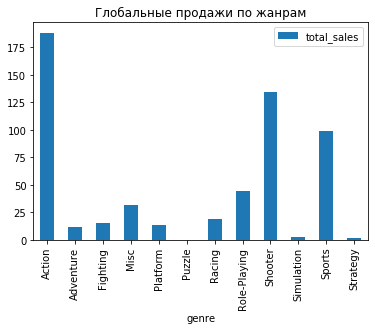

In [26]:
genre_sales.plot(kind='bar')
plt.title('Глобальные продажи по жанрам');

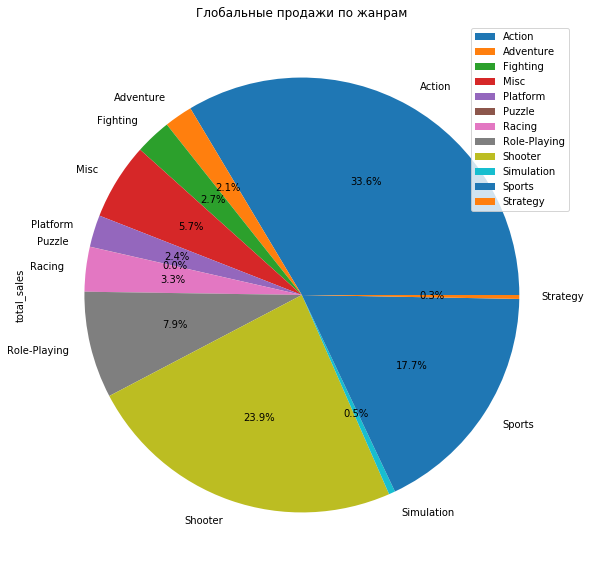

In [27]:
genre_sales.plot.pie(y='total_sales', autopct='%1.1f%%', figsize=(10, 10));
plt.title('Глобальные продажи по жанрам');

Лидеры продаж - Ation и Sports. Аутсайдеры - Puzzle, Adventure и Strategy.

## Исследование пользователей по регионам.

In [28]:
na_sales_table = data_top_5.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(10)
na_sales_table

,na_sales
platform,
PS4,108.74
X360,81.66
PS3,63.50
Wii,6.56
PSP,0.00


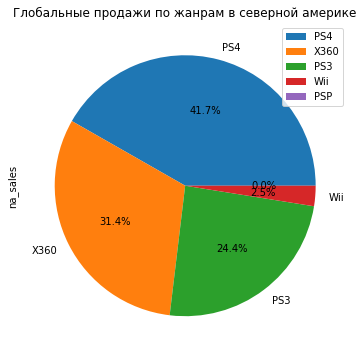

In [29]:
na_sales_table.plot.pie(y='na_sales', autopct='%1.1f%%', figsize=(6, 6));
plt.title('Глобальные продажи по жанрам в северной америке');

В США значительную долю занимают платформы X360 и PS4. Платформы серии Play Station в сумме выбиваются в лидеры.

In [30]:
eu_sales_table = data_top_5.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(10)
eu_sales_table

,eu_sales
platform,
PS4,141.09
PS3,67.81
X360,42.52
Wii,5.93
PSP,0.17


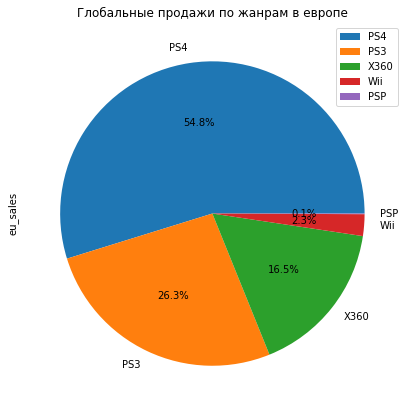

In [31]:
eu_sales_table.plot.pie(y='eu_sales', autopct='%1.1f%%', figsize=(7, 7));
plt.title('Глобальные продажи по жанрам в европе');

В Европе подавляющее большинство занимают  платформы серии Play Station.

In [32]:
jp_sales_table = data_top_5.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(10)
jp_sales_table

,jp_sales
platform,
PS3,23.35
PS4,15.96
PSP,3.29
X360,0.51
Wii,0.05


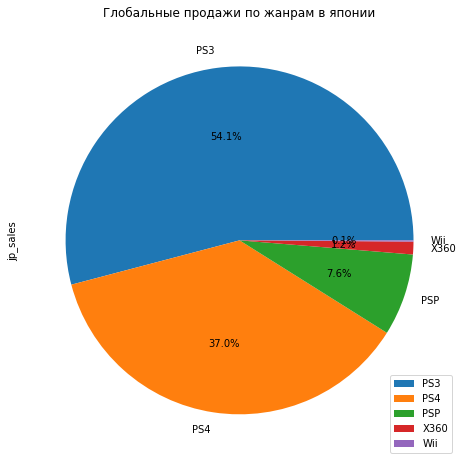

In [33]:
jp_sales_table.plot.pie(y='jp_sales', autopct='%1.1f%%', figsize=(8, 8));
plt.title('Глобальные продажи по жанрам в японии');

В Японии ситуация аналогична, за исключением того, что в лидерах 3 серия, а не 4.

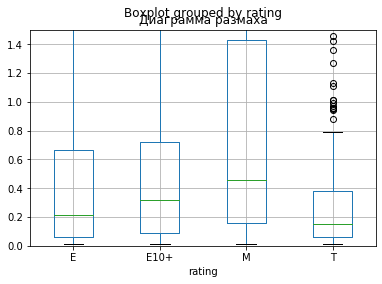

In [34]:
#Строим диаграммы размаха для столбца категория рейтинга
data_top_5.boxplot(column='total_sales', by='rating')
plt.ylim(0,1.5)
plt.title('Диаграмма размаха');
plt.show()

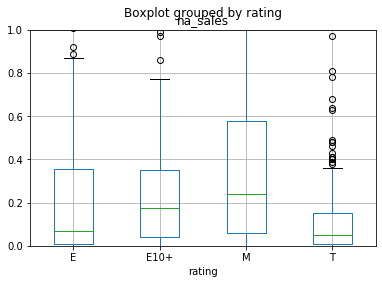

In [35]:
#Строим диаграммы размаха для столбца категория рейтинга
data_top_5.boxplot(column='na_sales', by='rating')
plt.ylim(0,1)
plt.show()

Наибольшие продажи в категориях M и E10+.

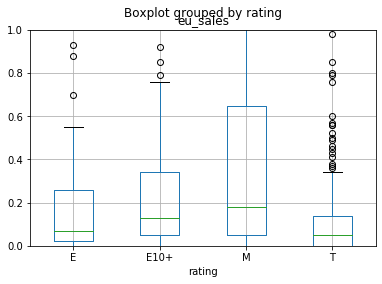

In [36]:
#Строим диаграммы размаха для столбца категория рейтинга
data_top_5.boxplot(column='eu_sales', by='rating')
plt.ylim(0,1)
plt.show()

В Европе наибольшие продажи судя по медиане происходят в категории M.

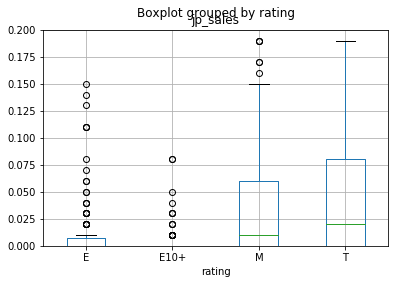

In [37]:
#Строим диаграммы размаха для столбца категория рейтинга
data_top_5.boxplot(column='jp_sales', by='rating')
plt.ylim(0,0.2)
plt.show()

В итоге картина такова, что в Японии наиболее продаваемы категории T (Teen) и M.

## . Проверка гипотез

Нулевая гипотеза - считаем, что средние пользовательские рейтинги одинаковые для платформ XBox One и PC. Альтернативная гипотеза - обратна нулевой гипотезе.
equal_var считаем false, поскольку я быть может наивно считаю, что игровые платформы типа xbox, play station и подобные более приспособлены для игр нежели старичок PC.

In [38]:
data = data.dropna(subset=['user_score'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7457 entries, 0 to 16705
Data columns (total 12 columns):
name               7457 non-null object
platform           7457 non-null object
year_of_release    7457 non-null int64
genre              7457 non-null object
na_sales           7457 non-null float64
eu_sales           7457 non-null float64
jp_sales           7457 non-null float64
other_sales        7457 non-null float64
critic_score       6891 non-null float64
user_score         7457 non-null float64
rating             7374 non-null object
total_sales        7457 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 757.4+ KB


In [39]:
xone_rate = data.query('platform == "XOne"')
variance_estimate_1 = np.var(xone_rate['user_score'])
xone_rate_od = xone_rate['user_score']
pc_rate = data.query('platform == "PC"')
variance_estimate_2 = np.var(pc_rate['user_score'])
pc_rate_od = pc_rate['user_score']
print(variance_estimate_1)
print(variance_estimate_2)
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(xone_rate_od, pc_rate_od)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1.8965188383045526
2.348969397210276
p-значение:  1.5093157588521831e-05
Отвергаем нулевую гипотезу


ЧТД

In [40]:
stat, p = levene(xone_rate['user_score'], pc_rate['user_score'])

p

0.2758248515551382

Нулевая гипотеза - считаем, что средние пользовательские рейтинги одинаковые для жанров Sports и Action. Альтернативная гипотеза - обратна нулевой гипотезе.
equal_var считаем True, поскольку у каждого жанра есть свои приверженцы и любители, следовательно средняя оценка будет приблизительно одинаковой.

In [41]:
action_rate = data.query('genre == "Action"')
variance_estimate_1 = np.var(action_rate['user_score'])
action_rate_od = action_rate['user_score']
sports_rate = data.query('genre == "Sports"')
variance_estimate_2 = np.var(sports_rate['user_score'])
sports_rate_od = sports_rate['user_score']
print(variance_estimate_1)
print(variance_estimate_2)
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(sports_rate_od, action_rate_od)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

2.026168592732831
2.6206293039045456
p-значение:  0.06701998404433748
Не получилось отвергнуть нулевую гипотезу


In [42]:
stat, p = levene(action_rate['user_score'], sports_rate['user_score'])

p

8.741422946178697e-05

ЧТД

## . Общий вывод

Поскольку нам нужно спланировать компанию на следующий год, то будет достаточно данных за последние допустим 4-5 лет. Данные за 2012 - 2016 годы в целом без выдающихся в ту или иную сторону показателей. После быстрого роста конца нулевых и падения начала десятых можно сделать вывод, что индустрия игр вышла на условное "плато". То есть прорыва, как и падения ожидать маловероятно.
Средний срок жизни платформы 7-10 лет после которых продажи стремятся к нулю. Исходя из этого предположу, что актуальным периодом можно считать срок в 8 лет, исходя из количества выпускаемых по годам игр и среднего срока жизни платформы.

На данный момент в живых платформах может числится разве что PS4. Остальные либо находятся в практически в стадии минимальных продаж без переспектив роста, либо уж отсутствуют в продажах.
Наиболее максимальный разброс в играх на платформах X360 и Wii. Медиана платформы X360 выше, что говорит о больших продажах в актуальном периоде. Но стоит заметить, что большие продажи в прошлом и в данный момент в конце 2016 года продажи в сравнении с серией PS минимальны.

Лидеры продаж - игры в жанрах Ation и Sports. Аутсайдеры - Puzzle, Adventure и Strategy.
На данный момент в лидерах игры жанров Sports, Action, Shooter на платформах PS3 и PS4. Хотя стоит заметить, что продажи игр на PS3 в данный момент находится в нисходящем тренде. PS4 в более выигрышном положении, хотя пик продаж тоже пройден. 